# Hedging Strategy

## Introduction

The objective of this project is to explore and implement various hedging strategies—Beta Hedging to limit portfolio risks effectively. The portfolio comprises a selection of 5 to 10 stocks from diverse sectors to ensure diversification and reflect real-world market scenarios.  
Through the use of Monte Carlo simulations, the project evaluates the performance of these hedging strategies under different market conditions.  
Additionally, the study investigates the optimal frequency of dynamic hedging adjustments (daily, weekly, or conditional on specific portfolio variations) to minimize risk exposure while maintaining cost efficiency.

## Assumptions
We make some assumption to focus only on the hedging aspect:

**1. No Transaction Costs:**  
Trading costs such as commissions, slippage, and bid-ask spreads are ignored in this analysis to focus solely on hedging effectiveness.

**2. Risk-Free Rate:**  
A constant risk-free rate (e.g., 2% annually) is assumed for any calculations involving the cost of carry or option pricing.

**3. No Dividends:**
Stocks in the portfolio do not pay dividends, simplifying return calculations.

**4. Volatility:**    
Historical volatilities are assumed to be good proxies for future volatility.

**5. Hedging Instruments:**  
Options and futures contracts are assumed to be liquid and available for all underlying assets and indices.

**6. Equally Weighted Portfolio**:  
No adjustment of the portfolio and it is assumed equally weighted


# Importing usefull packages

In [235]:
#!pip install ace_tools_open
#!pip install numpy
#!pip install yfinance
#!pip install matplotlib.pyplot
#!pip install seaborn
#!pip install scipy
#!pip install scikit-learn

In [297]:
import yfinance as yf
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import ace_tools_open as tools

from datetime import datetime

from scipy.stats import skew, kurtosis, norm

from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing Data of the Asset

In [298]:
# Step 1: Define stock tickers and date range
tickers = ['AAPL', 'MSFT', 'NVDA', 'NFLX', 'XOM', 'TSLA', 'AMZN', 'GC=F']  # Stock and commodity tickers
market_index = ['^GSPC']
start_date = datetime(2020, 1, 1)  # Start date
end_date = datetime(2025, 1, 1)  # End date
interval = "1d"  # Daily data interval
Freq = 250  # Annual trading days
rf = 0.0421  # Risk-free rate

try:
    # Step 2: Download historical data
    # Fetch closing prices and drop missing data
    data = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close'].dropna()
    # Keep only date
    data.index = data.index.date
    data.index = pd.to_datetime(data.index)
    
    # Check if data was retrieved
    if data.empty:
        raise ValueError(f"No data for ticker '{ticker}'.")

    # Step 3: Calculate daily returns
    stock_returns = data.pct_change().dropna()  # Stock returns

    # Step 4: Compute statistics
    average_stock_returns = stock_returns.mean(axis=0)  # Mean returns
    stock_std = stock_returns.std(axis=0)  # Stock volatility
    portfolio_std = stock_returns.std(axis=1)  # Portfolio volatility

    # Step 5: Annualize returns and volatility
    annualize_returns_per_stock = average_stock_returns * Freq  # Stock annual returns
    annualize_std_per_stock = stock_std * np.sqrt(Freq)  # Stock annual volatility

    # Step 6: Success message
    print("Data collection completed successfully.")
    print(f"Data points collected: {len(data)}")

except Exception as e:
    # Handle errors
    print(f"An error occurred: {e}")


[*********************100%***********************]  8 of 8 completed

Data collection completed successfully.
Data points collected: 1258


In [299]:
try:
    # Step 2: Download historical market data for S&P 500
    # Fetch S&P 500 closing prices and drop missing values
    market_data = yf.download(market_index, start=start_date, end=end_date, period='1d')["Close"].dropna()
    market_data.index = market_data.index.date
    market_data.index = pd.to_datetime(market_data.index)

    # Check if data retrieval was successful
    if market_data.empty:
        raise ValueError(f"No data retrieved for ticker '{ticker}'.")

    # Convert the closing prices to a pandas Series
    if len(market_data.shape) != 1:  # Check if data has multiple columns
        market_prices = market_data.iloc[:, 0]  # Select first column
        market_returns = market_prices.pct_change().dropna()  # Compute daily returns
        average_market_returns = market_returns.mean()  # Average daily return
        average_market_std = market_returns.std()  # Daily return volatility
        annualize_market_return = average_market_returns * Freq  # Annualized return
        annualize_market_std = average_market_std * np.sqrt(Freq)  # Annualized volatility
    
    else:  # Handle single-column data
        market_prices = market_data
        market_returns = market_prices.pct_change().dropna()
        average_market_returns = market_returns.mean()
        average_market_std = market_returns.std()
        annualize_market_return = average_market_returns * Freq
        annualize_market_std = average_market_std * np.sqrt(Freq)

    # Print success message and data summary
    print("Data collection completed successfully.")
    print(f"Data points collected: {len(market_data)}")

except Exception as e:
    # Handle errors
    print(f"An error occurred: {e}")


[*********************100%***********************]  1 of 1 completed

Data collection completed successfully.
Data points collected: 1258


# Vizualising the data

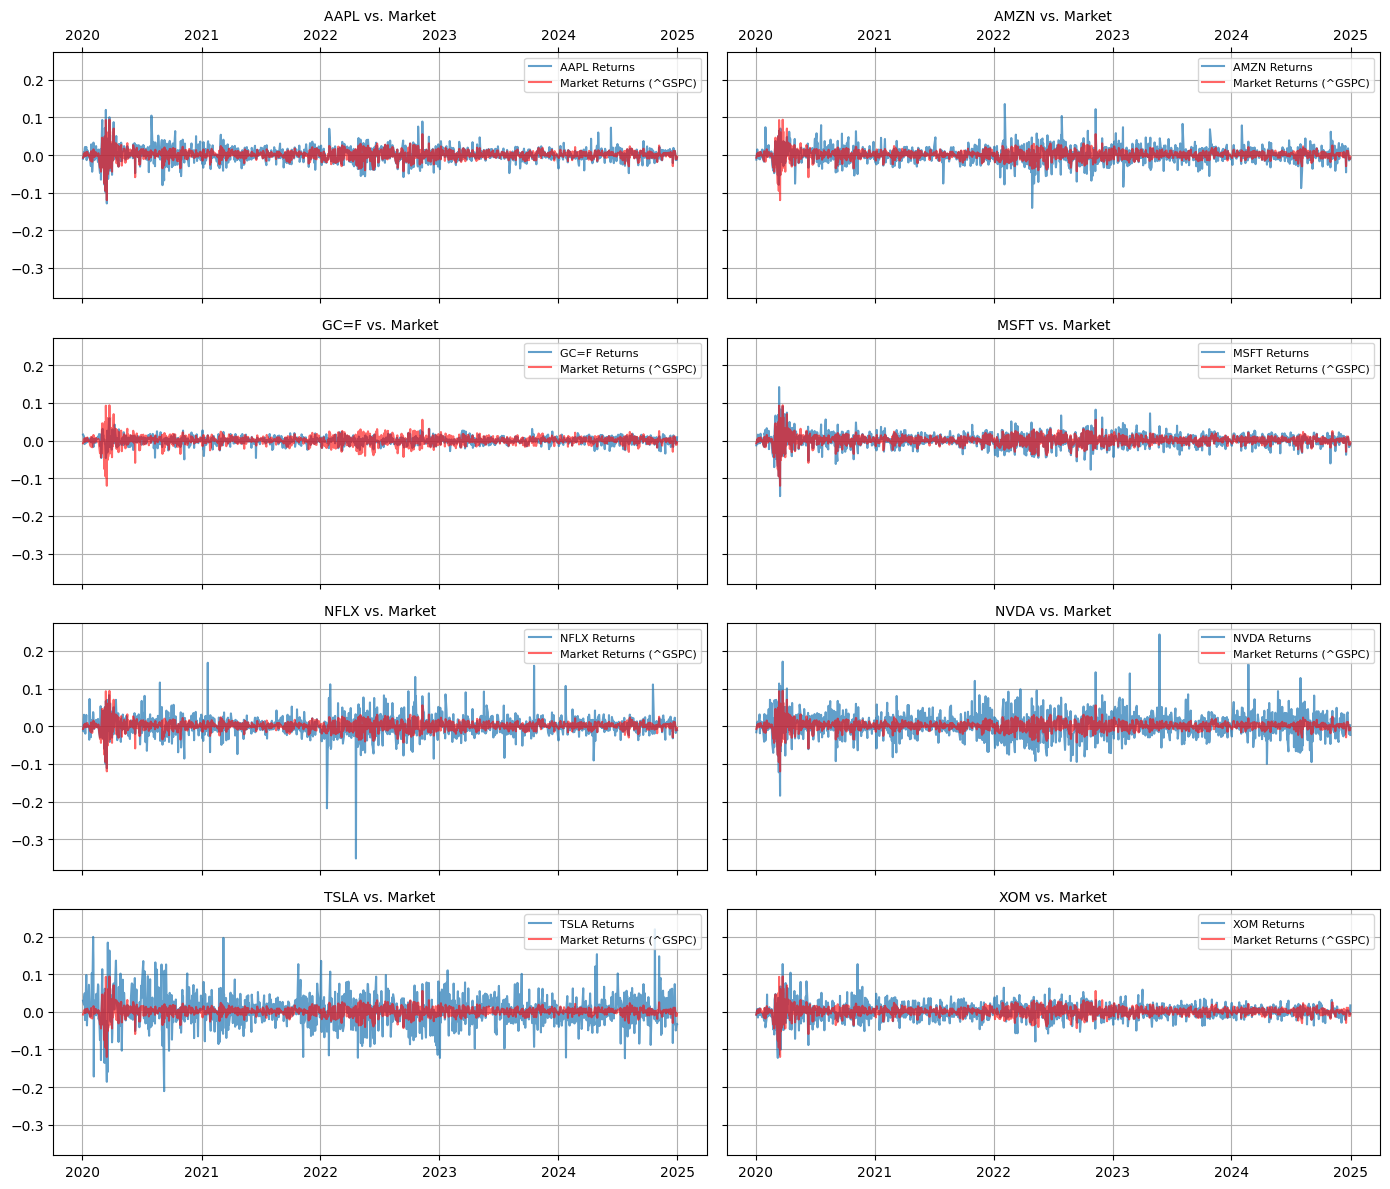

In [300]:
# Define the number of subplots
n = len(stock_returns.columns)  # Number of stocks
col = 2  # Number of subplot columns
row = int(np.ceil(n / col))  # Calculate required rows

# Create a figure with subplots
fig, ax = plt.subplots(
    row, 
    col,
    figsize=(14, 12),  # Plot size
    sharey=True,  # Share y-axis
    sharex=True,  # Share x-axis
)

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Iterate over each stock and its respective subplot
for i, stock in enumerate(stock_returns.columns):
    # Plot stock returns
    ax[i].plot(stock_returns.index, stock_returns[stock], label=f"{stock} Returns", alpha=0.7)
    
    # Plot market returns
    ax[i].plot(market_returns.index, market_returns, label=f"Market Returns ({market_returns.name})", color='red', alpha=0.6)
    
    # Customize the subplot
    ax[i].set_title(f"{stock} vs. Market", fontsize=10)
    ax[i].grid(True)
    ax[i].legend(loc='upper right', fontsize=8)

# Customize x-axis for top row
for i in range(col):  
    ax[i].xaxis.set_tick_params(which='both', top=True, labeltop=True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show();

# Statistics

In [301]:
# Function to calculate annualized Sharpe Ratio
def annualize_sr(returns, std, rf):
    return (returns - rf) / std  # Risk-adjusted return measure

In [302]:
n_dec = 2  # Round results to 2 decimals

# Create a summary DataFrame with tickers as the index
SumStat = pd.DataFrame(index=stock_returns.columns)

# Add annualized return, volatility, and Sharpe Ratio
SumStat['Mean(Annu,%)'] = np.round(annualize_returns_per_stock * 100, n_dec)
SumStat['Volatility(Annu,%)'] = np.round(annualize_std_per_stock * 100, n_dec)
SumStat['Sharpe Ratio (Annu)'] = np.round(annualize_sr(annualize_returns_per_stock, annualize_std_per_stock, rf=0.0421), n_dec)

# Add max/min prices and statistical properties
SumStat['Max Price'] = np.round(data.max(), n_dec)  # Highest price
SumStat['Min Price'] = np.round(data.min(), n_dec)  # Lowest price
SumStat['Skewness'] = np.round(stock_returns.skew(), n_dec)  # Distribution asymmetry
SumStat['Kurtosis'] = np.round(stock_returns.kurtosis(), n_dec)  # Distribution peakedness

# Display the summary table
display(SumStat)

,"Mean(Annu,%)","Volatility(Annu,%)",Sharpe Ratio (Annu),Max Price,Min Price,Skewness,Kurtosis
Ticker,,,,,,,
AAPL,29.55,31.55,0.80,259.02,54.51,0.11,5.28
AMZN,23.08,35.82,0.53,232.93,81.82,0.07,4.00
GC=F,12.16,16.20,0.49,2788.50,1477.30,-0.24,3.61
MSFT,24.70,30.38,0.67,465.79,129.88,-0.02,7.12
NFLX,30.43,45.34,0.58,936.56,166.37,-1.27,23.38
NVDA,76.25,53.66,1.34,148.87,4.89,0.42,4.01
TSLA,74.94,66.91,1.06,479.86,24.08,0.21,3.12
XOM,18.98,34.24,0.43,124.35,25.03,0.05,4.57


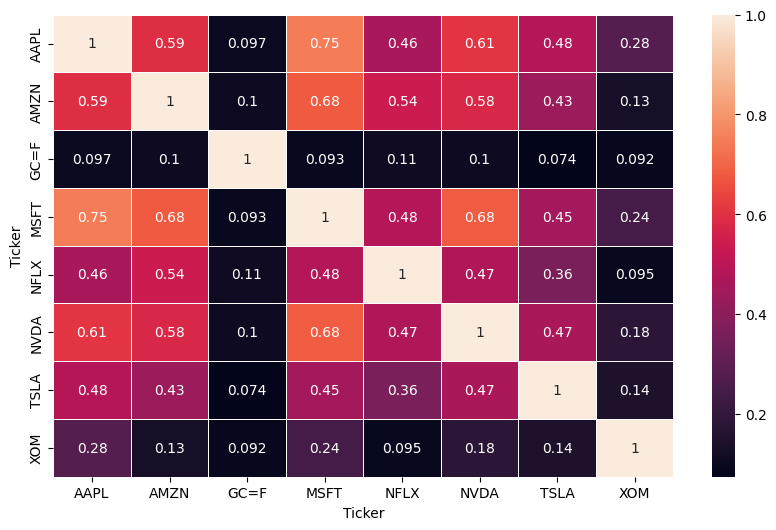

In [303]:
# Plot a heatmap of correlation between stock returns
f, ax = plt.subplots(figsize=(10, 6))  # Set the figure size
sns.heatmap(stock_returns.corr(), annot=True, linewidths=0.5, ax=ax);  # Generate heatmap with annotations

# Beta Hedging 

## Calculating Beta

We are focusing only on the daily Beta, but this analysis can be extended to weekly, monthly, etc... Beta

In [304]:
steps_list = [len(data), 250, 200, 120, 60, 20, 10]  # List of step sizes for calculations
number_steps = len(steps_list)

# Filter step sizes to ensure they are <= the length of observed prices
steps_list = [step for step in steps_list if step <= len(data)]

# Notify if any step sizes were removed
if len(steps_list) < number_steps:
    print("Some steps were removed as they exceeded the data length.")
    print(f"Filtered steps_list: {steps_list}")

In [305]:
number_stocks = len(stock_returns.columns)
beta_list = np.zeros((len(steps_list), number_stocks))
i = 0

for step in steps_list:
    for ticker in enumerate(tickers):
        X = market_returns[-step:].values.reshape(-1, 1)  # Market returns
        y = stock_returns[tickers][-step:].values  # Stock returns

        # Align lengths of X and y
        min_length = min(len(X), len(y))
        X = X[:min_length]
        y = y[:min_length]

        reg = LinearRegression().fit(X, y)  # Linear regression

        beta = reg.coef_
        beta_list[i, :] = beta.flatten()  # Store beta

    i += 1

# Create DataFrame for alpha and beta
betas = pd.DataFrame(index=steps_list)

# Add beta columns
for i in range(len(tickers)):
    betas[f'Beta for {tickers[i]}'] = beta_list[:, i]

In [306]:
betas

,Beta for AAPL,Beta for MSFT,Beta for NVDA,Beta for NFLX,Beta for XOM,Beta for TSLA,Beta for AMZN,Beta for GC=F
1258,1.173311,1.174097,1.757701,1.024043,0.830939,1.577821,1.081117,0.096575
250,0.946021,1.188927,2.663689,1.141006,0.187820,2.373784,1.539998,0.194682
200,0.974213,1.136617,2.526968,1.140792,0.201338,2.624951,1.473342,0.233143
120,0.845028,1.045737,2.569459,1.058826,0.201474,2.850549,1.559734,0.207492
60,0.701751,1.208449,1.573958,1.148863,0.166151,2.985239,1.645406,0.103786
20,0.744033,1.050856,1.218814,1.333645,0.072225,3.141986,1.607781,0.310201
10,0.939117,0.980016,1.026666,1.145368,0.381732,2.665964,1.340624,0.241739


In [307]:
# Step 4: Portfolio beta calculation (weights sum to 1)
weights = 1 / len(tickers)  # Equal weights for simplicity
EW_portfolio_beta = []

for i in range(len(steps_list)):
    EW_portfolio_beta.append({
    "Estimation Period (days)": steps_list[i],
    "EW Betas": sum(weights * betas.iloc[i,:]),
    })

EW_portfolio_beta = pd.DataFrame(EW_portfolio_beta)
EW_portfolio_beta

,Estimation Period (days),EW Betas
0,1258,1.089451
1,250,1.279491
2,200,1.288921
3,120,1.292287
4,60,1.191700
5,20,1.184943
6,10,1.090153


**What is Beta?**  
  Beta is like a measure of how much a stock “dances” with the overall market. If the market moves up or down, beta tells you how much that stock might move in comparison. For example:

If beta = 1: The stock moves in step with the market.  
If beta > 1: The stock moves more than the market (higher risk, higher reward).  
If beta < 1: The stock moves less than the market (lower risk, lower reward).  

**Beta Doesn’t Stay the Same**  
Here’s the key thing: beta isn’t set in stone. It changes over time because:

Markets change: Big events, like financial crises or booms.  
Companies change: A company might launch new products, take on debt, or expand into new markets, all of which can make it more or less risky.  
Investors change: People’s perceptions of a stock can shift, which also impacts beta.  
S
o, you can’t just calculate beta once and expect it to work forever. It evolves.  

**Why Does the Period You Use Matter?**  
  When you calculate beta, you need to decide how much past data you’ll include. That’s what we call the estimation period, and it makes a big difference:

Longer periods (like 5 years or 1258 trading days in your example):  
They give you a big-picture view of the stock.   
They smooth out short-term noise (like a market dip or spike) and show how the stock behaves over time.   
But they might miss recent trends. For example, if a company has started doing something new, the old data won’t capture that.

Shorter periods (like 10 or 20 days):  
They show you what’s happening right now.  
They’re great if you want to understand the stock’s behavior in the short term.  
But they can be jumpy and may not reflect the stock’s overall character.  

**The Trade-Off**  
Here’s where it gets interesting: choosing your period is a balancing act. It depends on what you care about:

If you’re a long-term investor, you probably want the stability of a longer period. It’s like looking at the big picture.  
If you’re making short-term decisions (like trading), you might prefer shorter periods because they show what’s happening now.  
But here’s the catch: if you choose a short period, you might lose sight of the long-term trends. And if you go for a long period, you might miss the latest moves. It’s all about what fits your goals.

## Exemple of Beta Hedging

In [308]:
#Calculate the average returns with a EW portfolio
average_returns = stock_returns.mean(axis=1)

In [309]:
EW_portfolio_beta.iloc[1,1]

np.float64(1.2794907455350195)

means: 19.54937272171407 | 36.25909814479595
volatility: 14.219908648883681 | 27.086879668546594


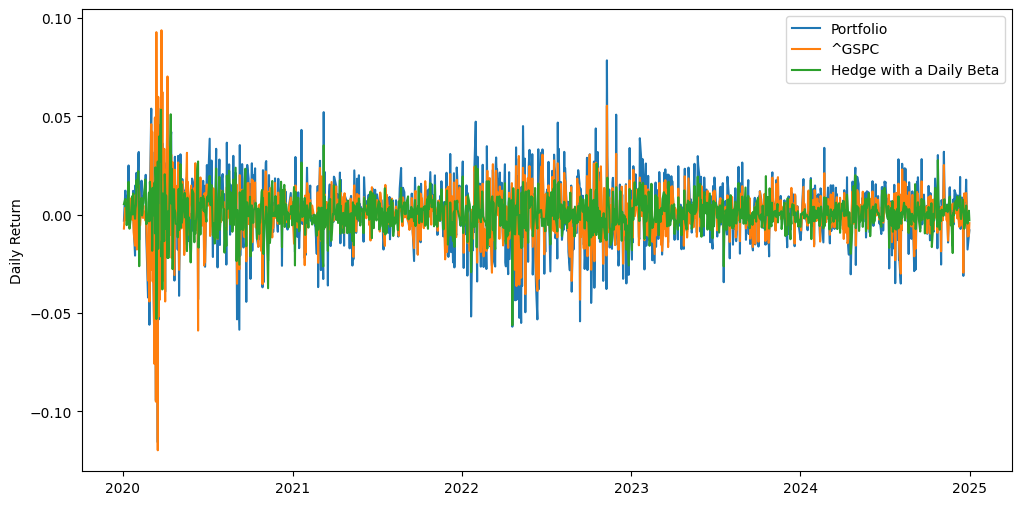

In [310]:
# Build an Hedged Portfolio with Beta
portfolio_returns = -1*EW_portfolio_beta.iloc[4,1]*market_returns + average_returns # Remplacer le Beta par le Delta 

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(average_returns, label='Portfolio')
plt.plot(market_returns, label=market_returns.name)
plt.plot(portfolio_returns, label='Hedge with a Daily Beta')
plt.ylabel('Daily Return')
plt.legend()

print("means:", (portfolio_returns.mean() * 250) * 100,'|', (average_returns.mean() * 250) * 100)
print("volatility:", (portfolio_returns.std() * np.sqrt(250)) * 100,'|', (average_returns.std() * np.sqrt(250)) * 100);

Beta Hedging Implementation: This example demonstrates a daily beta hedging strategy, where a portfolio's returns are adjusted to mitigate market risk.
The portfolio's beta used in this calculation was computed over the past year, but it was not dynamically updated or re-optimized during the simulation period.

Volatility Reduction: The beta hedge successfully reduces the volatility of the portfolio, as evidenced by the smoother movement of the "Hedge" line compared to the original portfolio.
The annualized volatility of the hedged portfolio is significantly lower compared to the unhedged portfolio.

Limitations of Static Beta: The beta was not dynamically updated, which means the hedge does not fully account for fluctuations in the portfolio's exposure to market movements over time.
As market conditions and correlations change, the static beta becomes less effective, resulting in imperfect risk reduction.

## Choosing the Optimal Beta 

In [311]:
results = []  # Store the metrics for each estimation period

for i in range(len(steps_list)):
    # Calculate the hedged portfolio using the beta for this estimation period
    hedged_portfolio = -1*EW_portfolio_beta.iloc[i,1] * market_returns.iloc[-250:] + average_returns.iloc[-250:]

    # Calculate metrics for the hedged portfolio
    tracking_error = np.std(hedged_portfolio - market_returns.iloc[-250:])  # Deviation from market returns
    hedging_effectiveness = 1 - (np.var(hedged_portfolio) / np.var(average_returns.iloc[-250:]))  # Risk reduction
    avg_hedged_return = hedged_portfolio.mean()  # Average return of the hedged portfolio
    annualized_return = avg_hedged_return * Freq # Annualized return
    annualized_volatility = np.std(hedged_portfolio) * np.sqrt(Freq)  # Annualized volatility
    sharpe_ratio_hedged = (annualized_return - rf) / annualized_volatility  # Sharpe ratio

    # Beta stability: Standard deviation of betas over this period
    beta_stability = np.std(betas.iloc[i,:])

    # Append the results for this beta
    results.append({
        "Estimation Period (days)": steps_list[i],
        "Tracking Error": tracking_error,
        "Hedging Effectiveness (%)": hedging_effectiveness * 100,
        "Annualized Return (%)": annualized_return * 100,
        "Annualized Volatility (%)": annualized_volatility * 100,
        "Sharpe Ratio (Hedged)": sharpe_ratio_hedged,
        "Beta Stability (%)": beta_stability * 100,
    })

# Convert the results into a DataFrame for comparison
results_df = pd.DataFrame(results)

# Display the results for analysis
results_df

,Estimation Period (days),Tracking Error,Hedging Effectiveness (%),Annualized Return (%),Annualized Volatility (%),Sharpe Ratio (Hedged),Beta Stability (%)
0,1258,0.008778,72.808018,23.115164,9.724574,1.944061,46.854006
1,250,0.009940,74.450435,18.720064,9.426314,1.539315,84.324405
2,200,0.010000,74.446391,18.501980,9.427060,1.516059,85.098697
3,120,0.010022,74.442988,18.424118,9.427688,1.507699,92.282604
4,60,0.009391,74.099937,20.750410,9.490751,1.742793,86.935507
5,20,0.009349,74.043899,20.906700,9.501012,1.757360,88.372553
6,10,0.008782,72.820138,23.098917,9.722407,1.942823,69.007277


The code evaluates the performance of a hedged portfolio using different beta estimation periods. It calculates key metrics for each period, like tracking error, risk reduction, returns, volatility, and stability, to help determine the best estimation period for your goals.

**Tracking Error:**

Measures how closely the hedged portfolio tracks the market returns.  
Lower tracking error means the portfolio stays closer to the market's movements, which is ideal for minimizing deviations.

**Hedging Effectiveness (%):**

Represents how well the hedging reduces risk (variance of returns).  
Higher percentages mean better risk reduction, showing the beta used is effective.

**Annualized Return (%):**

The average return the hedged portfolio generates over time, scaled to a yearly figure.  
This tells you how profitable the portfolio is.

**Annualized Volatility (%):**

Measures the risk or uncertainty in the portfolio’s returns over time.  
Lower volatility suggests the portfolio is more stable.

**Sharpe Ratio (Hedged):**

A measure of risk-adjusted return. It tells you how much return the portfolio generates per unit of risk.  
Higher Sharpe ratios mean better risk-adjusted performance.

**Beta Stability (%):**

Shows how consistent beta values are across the chosen period.  
Higher stability suggests that the beta used is less sensitive to short-term noise, making it more reliable.  

**Observations from the Results:**

Longer Estimation Periods (e.g., 1258 days):
- Pros:
High beta stability: These periods give more consistent beta values, making them more reliable for long-term strategies.
Balanced Sharpe ratio and annualized return.
- Cons:
Lower hedging effectiveness compared to shorter periods. They may not capture the recent changes in market dynamics.

Shorter Estimation Periods (e.g., 10, 20, or 60 days):
- Pros:
Higher hedging effectiveness: These periods capture short-term trends better, leading to better risk reduction.
Competitive returns and Sharpe ratios.
- Cons:
Lower beta stability: The beta is more volatile and may not be as reliable for long-term planning.
Medium Periods (e.g., 120, 200 days):

**These often strike a balance:**

Decent beta stability.
Good hedging effectiveness and Sharpe ratio.
Suitable for investors looking for a middle ground between long-term reliability and short-term responsiveness.

**The Trade-Off:**

Short Periods: Great for capturing fast-changing market trends but can be less stable and overly reactive to short-term noise.  
Long Periods: Better for long-term strategies with consistent betas but less effective at responding to recent shifts in market dynamics.  
Medium Periods: A compromise, providing good balance across all metrics.  

## Beta With Different Frequency

In [312]:
# Define update frequencies and initialize beta_values dictionary
update_frequency = ['D', 'W', 'M']  # Daily, Weekly, Monthly
beta_values = {}

# Loop through frequencies
for freq in update_frequency:
    # Calculate stock and market returns based on frequency
    if freq != 'D':  # For weekly and monthly data
        stock_returns_test = data.resample(freq).last().pct_change().replace(0, np.nan).dropna(how='all')
        market_returns_test = market_prices.resample(freq).last().pct_change().replace(0, np.nan).dropna(how='all')
    else:  # For daily data
        stock_returns_test = data.pct_change().dropna()
        market_returns_test = market_prices.pct_change().dropna()
    
    # Initialize nested dictionary for the current frequency
    beta_values[freq] = {}

    # Loop through tickers and calculate betas
    for ticker in tickers:
        # Align stock and market returns
        X = market_returns_test.values.reshape(-1, 1)  # Market returns
        y = stock_returns_test[ticker].values  # Stock returns
        
        # Align lengths of X and y
        min_length = min(len(X), len(y))
        X = X[:min_length]
        y = y[:min_length]

        # Fit linear regression and store beta
        reg = LinearRegression().fit(X, y)
        beta_values[freq][ticker] = reg.coef_[0]

# Convert beta_values to a DataFrame
beta_values = pd.DataFrame(beta_values)

In [313]:
beta_values

,D,W,M
AAPL,1.173311,1.078392,1.210800
MSFT,1.174097,0.970481,0.901854
NVDA,1.757701,1.629412,1.636843
NFLX,1.024043,1.021489,1.269597
XOM,0.830939,0.821014,0.902581
TSLA,1.577821,1.990754,2.344997
AMZN,1.081117,0.943798,1.152189
GC=F,0.096575,0.251800,0.177713


In [314]:
average_EW_betas = beta_values.mean(axis=0)
average_EW_betas

D    1.089451
W    1.088392
M    1.199572
dtype: float64


=== Hedging with D Beta ===
Mean Annualized Returns: Hedged = 20.98% | Unhedged = 36.26%
Annualized Volatility: Hedged = 14.05% | Unhedged = 27.09%


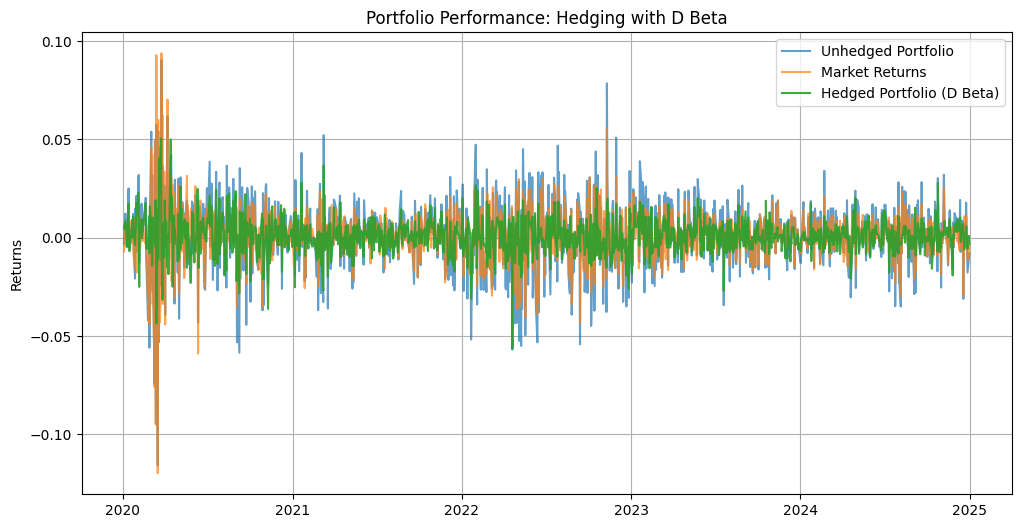


=== Hedging with W Beta ===
Mean Annualized Returns: Hedged = 19.68% | Unhedged = 34.27%
Annualized Volatility: Hedged = 13.18% | Unhedged = 25.12%


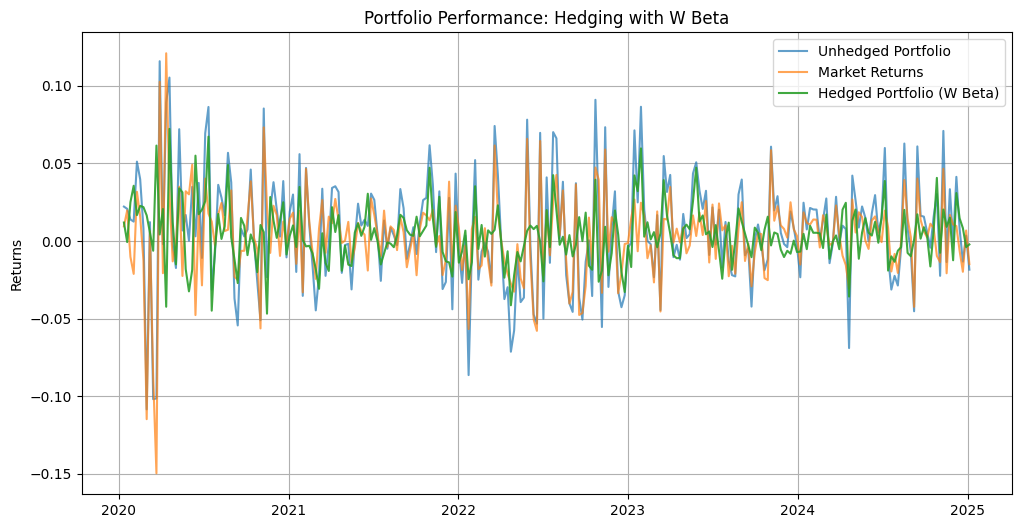


=== Hedging with M Beta ===
Mean Annualized Returns: Hedged = 18.55% | Unhedged = 35.27%
Annualized Volatility: Hedged = 14.47% | Unhedged = 26.33%


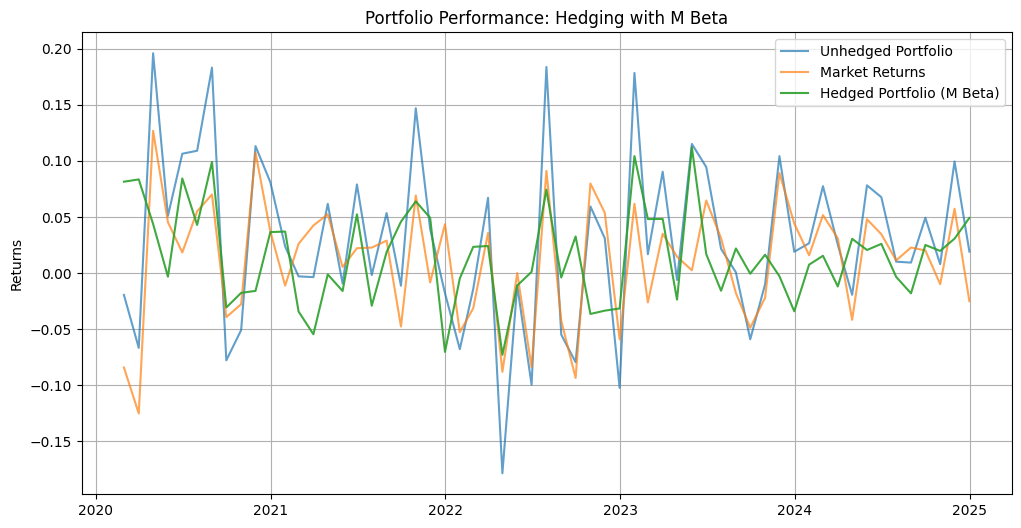

In [315]:
# Define update frequencies and corresponding annualization factors
update_frequency = ['D', 'W', 'M']  # Daily, Weekly, Monthly
freq_beta = [250, 50, 12]  # Annualization factors for each frequency

# Loop through each frequency to compute hedged portfolio performance
for i, freq in enumerate(update_frequency):
    # Resample stock and market returns based on the frequency
    if freq != 'D':  # For weekly and monthly data
        stock_returns_test = data.resample(freq).last().pct_change().replace(0, np.nan).dropna(how='all')
        market_returns_test = market_prices.resample(freq).last().pct_change().replace(0, np.nan).dropna(how='all')
    else:  # For daily data
        stock_returns_test = data.pct_change().dropna()
        market_returns_test = market_prices.pct_change().dropna()

    # Calculate average returns for the portfolio
    average_returns = stock_returns_test.mean(axis=1)  # Unhedged portfolio average returns

    # Construct a hedged portfolio using beta
    portfolio_returns = -1 * average_EW_betas.iloc[i] * market_returns_test + average_returns

    # Calculate performance metrics (annualized mean and volatility)
    annualized_mean_portfolio = portfolio_returns.mean() * freq_beta[i]
    annualized_mean_average = average_returns.mean() * freq_beta[i]
    
    annualized_vol_portfolio = portfolio_returns.std() * np.sqrt(freq_beta[i])
    annualized_vol_average = average_returns.std() * np.sqrt(freq_beta[i])

    # Print the performance summary
    print(f"\n=== Hedging with {freq} Beta ===")
    print(f"Mean Annualized Returns: Hedged = {annualized_mean_portfolio * 100:.2f}% | Unhedged = {annualized_mean_average * 100:.2f}%")
    print(f"Annualized Volatility: Hedged = {annualized_vol_portfolio * 100:.2f}% | Unhedged = {annualized_vol_average * 100:.2f}%")

    # Plot the performance
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(average_returns, label='Unhedged Portfolio', alpha=0.7)
    ax.plot(market_returns_test, label='Market Returns', alpha=0.7)
    ax.plot(portfolio_returns, label=f'Hedged Portfolio ({freq} Beta)', alpha=0.9)
    ax.set_ylabel('Returns')
    ax.set_title(f'Portfolio Performance: Hedging with {freq} Beta')
    ax.legend(loc='best')
    ax.grid(True)
    plt.show()

You are looking at beta estimation using different frequencies: daily (D), weekly (W), and monthly (M). The goal is to calculate and compare the performance of a hedged portfolio using betas derived from these different frequencies. The analysis measures how well the portfolio performs in terms of returns and volatility when market movements are hedged.

**Why Use Different Frequencies?**

1. Daily Beta:  
Captures very granular, short-term changes.  
Can respond to recent market movements quickly.  
But may be noisy and overly reactive to short-term volatility.  

2. Weekly Beta:  
Provides a balance between daily and monthly data.  
Smoother than daily but still captures medium-term trends.  

3. Monthly Beta:  
Focuses on longer-term trends, filtering out short-term noise.  
Might lag behind fast-changing market dynamics.  

**What Do the Charts and Metrics Show?**

1. Daily Beta:  
Hedging reduces portfolio volatility significantly.  
Returns are stable but slightly lower than the unhedged portfolio.  
Daily beta reacts quickly but can be noisy due to short-term fluctuations.  

2. Weekly Beta:  
Volatility is lower compared to unhedged.  
Returns remain competitive, with reduced risk.  
Weekly beta strikes a good balance between responsiveness and stability.  

3. Monthly Beta:  
Shows the lowest volatility reduction and relatively steady returns.  
Works well for long-term investors who prioritize stability over short-term movements.  

**The Trade-Off**

1. Daily Beta: Best for short-term strategies but more sensitive to noise.  
2. Weekly Beta: Offers a middle ground—responsive to trends while still providing smooth performance.  
3. Monthly Beta: Ideal for long-term strategies with lower sensitivity to recent change  

## Dynamic Beta

We will compute daily beta but again that could be extend to weekly, monthly, etc...

In [316]:
# Parameters for the rolling window and recalculation interval
rolling_window = 100  # Rolling window size for beta calculation
recalculation_interval = 10  # Frequency to recalculate beta
start_idx = rolling_window # Start of the taken data

dynamic_betas = []  # Store dynamic betas for each interval
hedged_portfolio = []  # Store hedged portfolio returns

# Iterate over the dataset with steps of recalculation_interval
for number_idx in range(rolling_window, len(data)):
    
    # Ensure the window has the required size
    if len(data[start_idx:number_idx]) == recalculation_interval:
        # Extract market and stock returns for the rolling window
        X = market_returns.iloc[start_idx-rolling_window : number_idx].values.reshape(-1, 1)  # Market returns
        y = stock_returns[tickers].iloc[start_idx-rolling_window : number_idx].values # Stock returns

        # Align lengths of X and y
        min_length = min(len(X), len(y))
        X = X[:min_length]
        y = y[:min_length]

        # Fit the linear regression model
        reg = LinearRegression().fit(X, y)
        beta = np.mean(reg.coef_)  # Average beta for the rolling window
        dynamic_betas.append(beta)  # Store the dynamic beta

        # Calculate the hedged returns for the next recalculation_interval
        next_end_idx = min(number_idx + recalculation_interval, len(market_returns))
        average_returns = stock_returns.iloc[number_idx:next_end_idx].mean(axis=1)
        hedged_returns = -1 * market_returns.iloc[number_idx:next_end_idx] * beta + average_returns

        # Append the hedged returns
        hedged_portfolio.extend(hedged_returns)

        start_idx = number_idx

# Convert the hedged portfolio to a pandas Series
portfolio_index = market_returns.index[rolling_window:rolling_window + len(hedged_portfolio)]
hedged_portfolio = pd.Series(hedged_portfolio, index=portfolio_index)

# Calculate annualized metrics for the hedged portfolio
annualized_mean_hedged = hedged_portfolio.mean() * 250
annualized_volatility_hedged = hedged_portfolio.std() * np.sqrt(250)

# Calculate annualized metrics for the unhedged portfolio
average_returns_stock = stock_returns.iloc[rolling_window : len(stock_returns)-recalculation_interval].mean(axis=1)
annualized_mean_unhedged = average_returns_stock.mean() * 250
annualized_volatility_unhedged = average_returns_stock.std() * np.sqrt(250)

=== Portfolio Performance ===
Mean Annualized Returns: Hedged = 15.352% | Unhedged = 34.922%
Annualized Volatility: Hedged = 12.874% | Unhedged = 24.580%


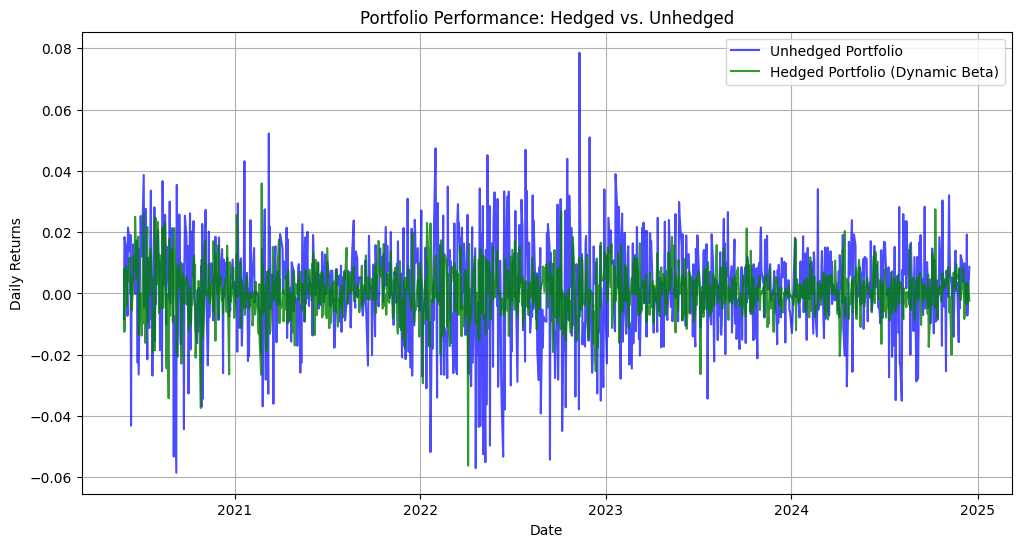

In [317]:
# Print performance metrics
print("=== Portfolio Performance ===")
print(f"Mean Annualized Returns: Hedged = {annualized_mean_hedged * 100:.3f}% | Unhedged = {annualized_mean_unhedged * 100:.3f}%")
print(f"Annualized Volatility: Hedged = {annualized_volatility_hedged * 100:.3f}% | Unhedged = {annualized_volatility_unhedged * 100:.3f}%")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(average_returns_stock.index, average_returns_stock, label="Unhedged Portfolio", color="blue", alpha=0.7)
plt.plot(hedged_portfolio.index, hedged_portfolio, label="Hedged Portfolio (Dynamic Beta)", color="green", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.title("Portfolio Performance: Hedged vs. Unhedged")
plt.legend(loc="best")
plt.grid(True)
plt.show()

**Why Does Hedging with Beta Perform Less Well?**  
The analysis highlights an important limitation of using beta for hedging: we use past information to hedge future risks. Let’s break this down step by step.

**The Challenge of Using Past Beta**  

Beta is Based on Historical Data:

Beta is calculated using a rolling window of past returns. It assumes the relationship between the stock and market (its "beta") will remain consistent in the future.  
But markets are dynamic, and this relationship can change due to new information, market shocks, or changes in the company's fundamentals. As a result, the beta you calculate today might not perfectly capture tomorrow’s reality.  

**No Future Information:**

In real-time hedging, we can only use data up to the present. This means we’re trying to predict the future based solely on the past—a method that inherently comes with some level of error.  
If we had access to future market movements (like in the hypothetical scenario where we use "future beta"), our hedges would align perfectly with the actual risks. But since we don't, there’s always a gap.  

**Market Noise and Dynamics:**

The market is influenced by countless factors, many of which are unpredictable. Even if beta is accurate for a period, sudden news or economic changes can disrupt the relationship between the stock and the market.  

**Hedging with Past Information**

Dynamic Beta: The rolling-window approach recalculates beta periodically based on the most recent data. This adds flexibility, but it still lags behind real-time changes in market relationships.  
The hedged portfolio performs better than the unhedged portfolio (lower volatility and smoother returns), but It doesn’t eliminate all risk because the beta used for hedging is always slightly outdated.  
The hedging effectiveness would be higher if we had access to future beta values.  

# Monte Carlo Simulations

In [318]:
# Function to simulate a portfolio and apply dynamic beta hedging
def simulate_portfolio(portfolio_stocks, market_returns, stock_returns, rolling_window, recalculation_interval):
    dynamic_betas = []
    hedged_portfolio = []
    start_idx = rolling_window
    
    for number_idx in range(rolling_window, len(data)):
        
        # Ensure the window has the required size
        if len(data[start_idx:number_idx]) == recalculation_interval:
            # Extract market and stock returns for the rolling window
            X = market_returns.iloc[start_idx - rolling_window:number_idx].values.reshape(-1, 1)  # Market returns
            y = stock_returns[portfolio_stocks].iloc[start_idx - rolling_window:number_idx].values # Stock returns
    
            # Align lengths of X and y
            min_length = min(len(X), len(y))
            X = X[:min_length]
            y = y[:min_length]
    
            # Fit the linear regression model
            reg = LinearRegression().fit(X, y)
            beta = np.mean(reg.coef_)  # Average beta for the rolling window
            dynamic_betas.append(beta)  # Store the dynamic beta
    
            # Calculate hedged returns for the next interval
            next_end_idx = min(number_idx + recalculation_interval, len(market_returns))
            average_returns = stock_returns[portfolio_stocks].iloc[number_idx:next_end_idx].mean(axis=1)
            hedged_returns = -1 * market_returns.iloc[number_idx:next_end_idx] * beta + average_returns
    
            # Append the hedged returns
            hedged_portfolio.extend(hedged_returns)
    
            start_idx = number_idx
    
    # Convert the hedged portfolio to a pandas Series
    portfolio_index = market_returns.index[rolling_window:rolling_window + len(hedged_portfolio)]
    hedged_portfolio = pd.Series(hedged_portfolio, index=portfolio_index)
    
    # Calculate performance metrics
    stocks_returns = stock_returns.iloc[rolling_window : len(stock_returns)-recalculation_interval].mean(axis=1)
    annualized_mean_hedged = hedged_portfolio.mean() * 250
    annualized_volatility_hedged = hedged_portfolio.std() * np.sqrt(250)
    hedging_effectiveness = 1 - np.var(hedged_portfolio) / np.mean(np.var(stock_returns))

    return annualized_mean_hedged, annualized_volatility_hedged, hedging_effectiveness, dynamic_betas
    

In [319]:
####################################
    ##This code can take times##
####################################

# Parameters for Monte Carlo simulation
num_simulations = 100  # Number of random portfolios
rolling_window = 100  # Rolling window size for beta calculation
recalculation_interval = 1  # Frequency to recalculate beta

results = []  # To store results for each simulation

# Monte Carlo Simulation
for _ in range(num_simulations):
    # Randomly select stocks for the portfolio
    num_stocks = np.random.randint(3, len(tickers))  # Randomly select between 2 and total available stocks
    portfolio_stocks = np.random.choice(tickers, num_stocks, replace=False)  # Select random stocks

    # Simulate the portfolio and hedging strategy
    mean_return, volatility, effectiveness, betas = simulate_portfolio(portfolio_stocks, market_returns, stock_returns, rolling_window, recalculation_interval)

    # Store results
    results.append({
        'Portfolio': portfolio_stocks,
        'Mean Return (%)': mean_return * 100,
        'Volatility (%)': volatility * 100,
        'Hedging Effectiveness (%)': effectiveness * 100
    })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

In [320]:
results_df.sort_values(ascending=True, by='Hedging Effectiveness (%)')

,Portfolio,Mean Return (%),Volatility (%),Hedging Effectiveness (%)
99,"[TSLA, AAPL, AMZN]",14.795095,23.104041,69.607752
49,"[NVDA, NFLX, MSFT]",20.797318,21.594122,73.450397
67,"[AMZN, AAPL, NVDA, TSLA]",22.450379,21.461280,73.776047
18,"[TSLA, AMZN, NVDA, MSFT]",21.044297,21.306951,74.151846
36,"[NVDA, NFLX, XOM, TSLA]",27.087593,20.812668,75.337197
...,...,...,...,...
85,"[GC=F, NVDA, AAPL, AMZN, XOM]",15.642176,10.876144,93.265012
75,"[NVDA, GC=F, AAPL, MSFT, XOM]",16.684960,10.205958,94.069457
22,"[AMZN, AAPL, NVDA, XOM, GC=F, MSFT]",13.807454,10.082071,94.212561
44,"[NVDA, AMZN, GC=F, MSFT, XOM, AAPL]",13.807454,10.082071,94.212561


In [321]:
results_df.sort_values(ascending=False, by='Hedging Effectiveness (%)')

,Portfolio,Mean Return (%),Volatility (%),Hedging Effectiveness (%)
47,"[XOM, AAPL, GC=F, AMZN]",8.198663,10.036460,94.264807
22,"[AMZN, AAPL, NVDA, XOM, GC=F, MSFT]",13.807454,10.082071,94.212561
44,"[NVDA, AMZN, GC=F, MSFT, XOM, AAPL]",13.807454,10.082071,94.212561
75,"[NVDA, GC=F, AAPL, MSFT, XOM]",16.684960,10.205958,94.069457
85,"[GC=F, NVDA, AAPL, AMZN, XOM]",15.642176,10.876144,93.265012
...,...,...,...,...
21,"[XOM, NFLX, TSLA, NVDA]",27.087593,20.812668,75.337197
18,"[TSLA, AMZN, NVDA, MSFT]",21.044297,21.306951,74.151846
67,"[AMZN, AAPL, NVDA, TSLA]",22.450379,21.461280,73.776047
49,"[NVDA, NFLX, MSFT]",20.797318,21.594122,73.450397


In [322]:
print(results_df['Hedging Effectiveness (%)'].mean()) #Average of the Hedging Effectiveness

86.5476395703741


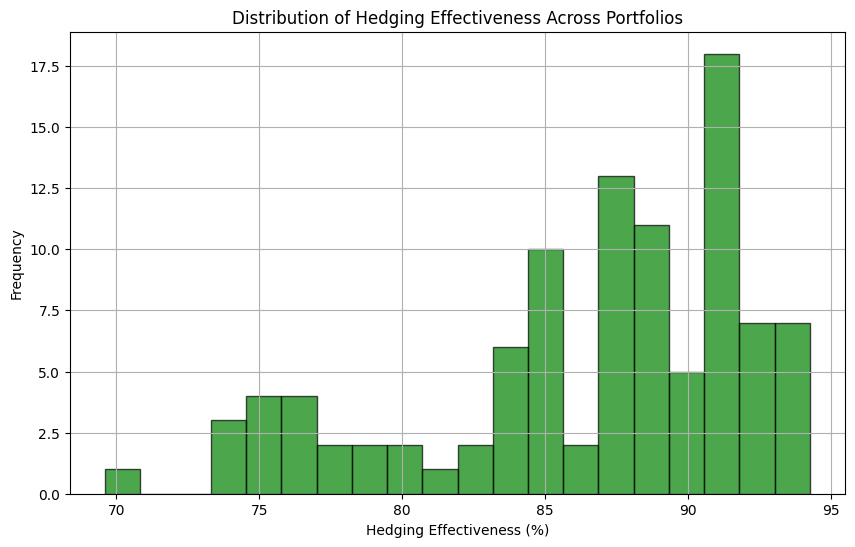

In [323]:
# Visualize the distribution of hedging effectiveness
plt.figure(figsize=(10, 6))
plt.hist(results_df['Hedging Effectiveness (%)'], bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title("Distribution of Hedging Effectiveness Across Portfolios")
plt.xlabel("Hedging Effectiveness (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

This analysis simulates different portfolios and tests how well dynamic beta hedging performs across various setups.

**Dynamic Beta Hedging:**

For each portfolio, dynamic betas are calculated using a rolling window and applied to hedge market movements.  
The performance of the hedged portfolio is measured in terms of mean return, volatility, and hedging effectiveness.  

**Monte Carlo Simulations:**

Random portfolios are generated, each consisting of randomly selected stocks.  
For each portfolio, the hedging strategy is tested, and performance metrics are recorded.

**Distribution of Hedging Effectiveness:**

A histogram shows how effective the hedging strategy is across the simulated portfolios.
The histogram shows that most portfolios achieve 80-90% effectiveness, meaning hedging significantly reduces risk for most setups.  
A few portfolios fall below this range, likely due to mismatched beta calculations or stock selections   

Unstable Beta: Volatile stocks or short rolling windows can cause inconsistent beta estimates, making hedging less precise.  
Low Market Correlation: Stocks like gold (GC=F) or defensive sectors don’t track the market well, reducing beta's effectiveness.  
Small Portfolios: Portfolios with too few stocks are more exposed to individual stock risks, which beta can’t hedge.  
Lag in Dynamic Beta: Beta uses past data and can’t adapt fast enough to sudden market shifts.

**Trade-Off Between Return and Volatility:**

Portfolios with higher hedging effectiveness tend to have lower volatility but may experience reduced returns.  
This highlights the classic risk-return trade-off in hedging strategies.

**Dynamic Beta Adds Flexibility:**

By recalculating beta at regular intervals, the strategy adapts to changing market conditions.  
This makes it more effective than a static beta approach but still limited by the lag in using past data.  

**Insights from the Simulations**

Why Effectiveness Varies:  
The effectiveness of the hedge depends on how well the dynamic beta captures the relationship between the portfolio and the market.  
Some portfolios may contain stocks with highly unstable betas, reducing the hedge’s accuracy.  

**Impact of Random Portfolios:**

Different combinations of stocks lead to varying levels of diversification and correlation with the market.
Portfolios with high correlation to the market tend to benefit more from hedging.

**The Lag Effect:**

As mentioned earlier, dynamic beta is calculated using historical data. While it adapts over time, it cannot perfectly predict future market movements.  
This lag is why even the best-performing portfolios don’t achieve 100% hedging effectiveness.  

# Conclusion

This project demonstrates the effectiveness of dynamic beta hedging in reducing portfolio volatility while balancing returns. Through simulations, we observed that hedging significantly decreases risk for most portfolios, though its success depends on factors like beta stability, portfolio composition, and market dynamics.

**Adapting to Real-World Scenarios**  
To make this model more applicable to real-world trading, we could relax some of the assumptions:

1. Incorporate Transaction Costs: Including trading costs (commissions, slippage, bid-ask spreads) would provide a more realistic measure of hedging performance.
2. Variable Risk-Free Rates: Allowing for dynamic risk-free rates would reflect changing economic conditions.
3. Account for Dividends: Adjusting for dividends would make the portfolio return calculations more accurate.
4. Imperfect Market Liquidity: Factoring in the liquidity constraints of hedging instruments like options and futures would enhance realism.
5. Weighted Portfolios: Allowing for unequal weightings would better represent typical portfolio allocations.

By addressing these factors, the model can be further refined to better mirror the complexities of actual market conditions.